# Customer Segmentation

This notebook runs the full segmentation pipeline: loading the data (uses the `market` sheet), feature engineering, clustering (KMeans), evaluation and visualizations. It also summarizes findings and actionable recommendations so you can export or present results directly from the notebook.

Assumptions:
- The repository contains `data_processing.py`, `features.py`, and `pipeline.py` which this notebook may import.
- Data source: `Supermarket Data.xlsx` downloaded from the Kaggle dataset into a cache; `data_processing.load_raw()` will prefer the `market` sheet.


In [28]:
# 1) Imports and environment
import sys
from pathlib import Path
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added repo root to sys.path:', repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Helpers from this repo
from data_processing import load_raw
from features import build_transaction_features, build_store_aggregates

# Plot settings
%matplotlib inline
sns.set(style='whitegrid')

print('Notebook running with pandas', pd.__version__)


Added repo root to sys.path: C:\Users\jeff\Projects\customer_segmentation
Notebook running with pandas 2.3.3


In [29]:
# 2) Load data

# load_raw prefers the `market` sheet and handles column normalization
raw_df = load_raw()
print('Loaded dataframe shape:', raw_df.shape)
raw_df.head()


Loaded dataframe shape: (1464, 33)


C:\Users\jeff\Projects\customer_segmentation\data_processing.py:69: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')


,supermarket,no_of_items,variation,total,paid,change,type,food,snack,beverage,...,24hr,day_1,month,year,hour,item_no_cat,total_cat,paid_cat,change_cat,datetime
0,acacia,1,1,90.0,100,10.0,cash,yes,no,no,...,no,20,5,2017.0,19,A,1,1,1,2017-05-20 19:33:00
1,acacia,1,1,90.0,500,410.0,cash,yes,no,no,...,no,20,5,2017.0,19,A,1,1,1,2017-05-20 19:12:00
2,acacia,3,1,270.0,300,30.0,cash,yes,no,no,...,no,20,5,2017.0,19,B,1,1,1,2017-05-20 19:16:00
3,acacia,3,1,137.0,200,63.0,cash,yes,no,no,...,no,20,5,2017.0,19,B,1,1,1,2017-05-20 19:12:00
4,acacia,1,1,75.0,80,5.0,cash,yes,no,no,...,no,20,5,2017.0,18,A,1,1,1,2017-05-20 18:31:00


In [30]:
# 3) Quick inspection
print('Columns:', raw_df.columns.tolist())
print('\nMissing value counts (top 20):')
print(raw_df.isnull().sum().sort_values(ascending=False).head(20))

# Basic value counts for key categorical fields (if present)
for c in ['supermarket','payment_type','category']:
    if c in raw_df.columns:
        print(f"\nValue counts for {c} (top 10):")
        print(raw_df[c].value_counts().head(10))


Columns: ['supermarket', 'no_of_items', 'variation', 'total', 'paid', 'change', 'type', 'food', 'snack', 'beverage', 'consumables', 'high_end', 'asset', 'fixed_asset', 'date', 'mall', 'time', 'time_type', 'type_market', 'location', 'loc_category', 'day', 'day_type', '24hr', 'day_1', 'month', 'year', 'hour', 'item_no_cat', 'total_cat', 'paid_cat', 'change_cat', 'datetime']

Missing value counts (top 20):
datetime       3
year           2
supermarket    1
no_of_items    0
variation      0
change         0
type           0
total          0
paid           0
beverage       0
consumables    0
high_end       0
asset          0
fixed_asset    0
date           0
food           0
snack          0
time           0
mall           0
time_type      0
dtype: int64

Value counts for supermarket (top 10):
supermarket
karrymart     520
tumaini       268
nakumatt      180
cleanshelf    128
tuskys        126
ukwala         56
acacia         53
naivas         30
eastmatt       26
Tuskys         16
Name: co

In [31]:
# 4) Feature engineering

features = build_transaction_features(raw_df)
print('Features shape:', features.shape)
features.head()


Features shape: (1464, 13)


,no_of_items,variation,total,paid,change,hour,dayofweek,is_weekend,month,supermarket_freq,is_cash,is_card,is_mpesa
0,1,1,90.0,100,10.0,19.0,5.0,1,5.0,0.036202,1,0,0
1,1,1,90.0,500,410.0,19.0,5.0,1,5.0,0.036202,1,0,0
2,3,1,270.0,300,30.0,19.0,5.0,1,5.0,0.036202,1,0,0
3,3,1,137.0,200,63.0,19.0,5.0,1,5.0,0.036202,1,0,0
4,1,1,75.0,80,5.0,18.0,5.0,1,5.0,0.036202,1,0,0


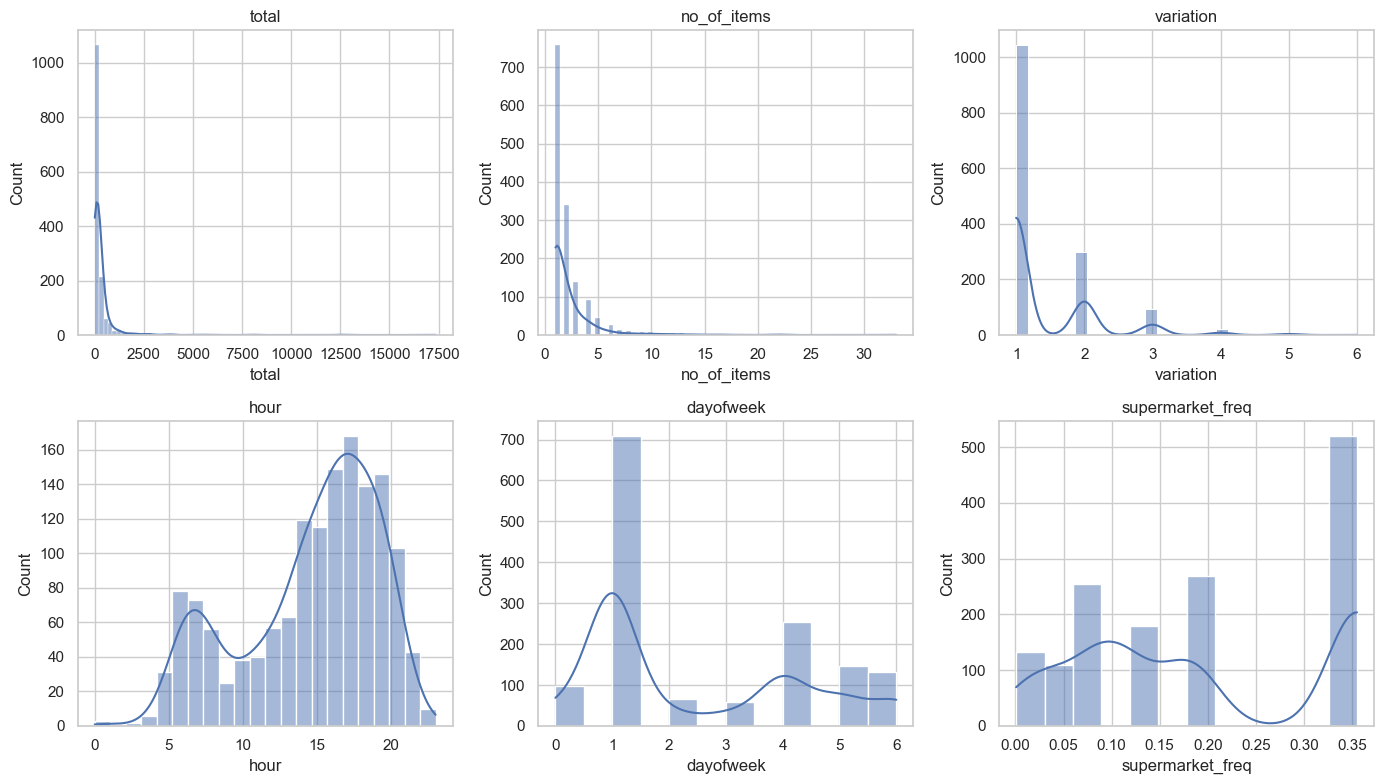

In [32]:
# 4b) Quick feature distributions
import matplotlib.pyplot as plt
fig_dist, axs = plt.subplots(2, 3, figsize=(14,8))
for ax, col in zip(axs.flatten(), ['total','no_of_items','variation','hour','dayofweek','supermarket_freq']):
    if col in features.columns:
        # pass the series to the `x` parameter to satisfy type checkers and the seaborn API
        sns.histplot(x=features[col], ax=ax, kde=True)
        ax.set_title(col)
plt.tight_layout()


k=2: silhouette=0.5988, inertia=15213.14
k=3: silhouette=0.2452, inertia=12680.09
k=4: silhouette=0.2640, inertia=10950.24
k=5: silhouette=0.2912, inertia=9292.62
k=6: silhouette=0.2957, inertia=7966.07
k=7: silhouette=0.2993, inertia=7094.07
k=8: silhouette=0.3206, inertia=6372.29


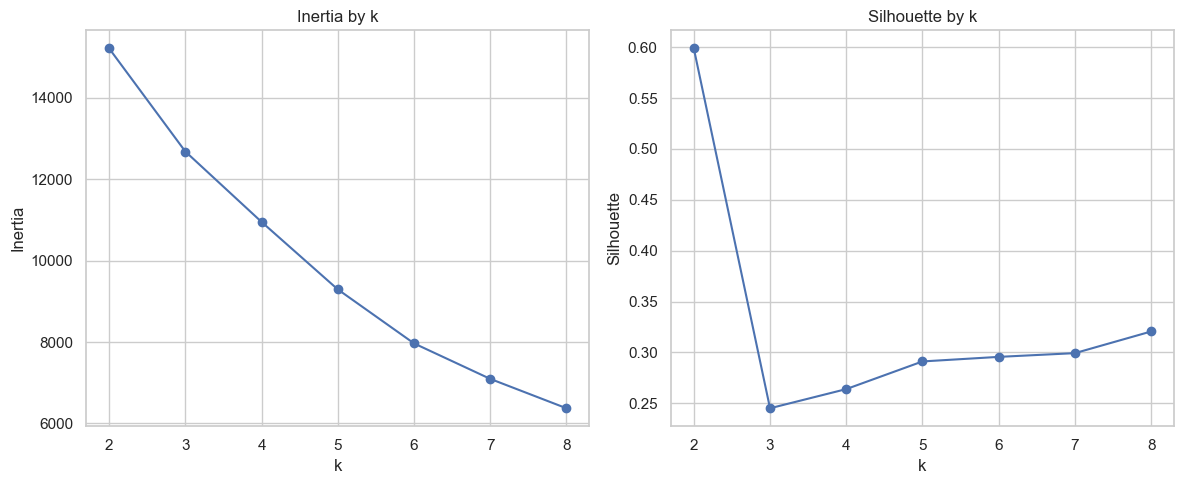

In [33]:
# 5) Scale and evaluate k
scaler = StandardScaler()
X = scaler.fit_transform(features)

ks = range(2,9)
scores = {}
inertias = {}
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    try:
        s = silhouette_score(X, labels)
    except Exception:
        s = float('nan')
    scores[k] = s
    inertias[k] = km.inertia_
    print(f'k={k}: silhouette={s:.4f}, inertia={km.inertia_:.2f}')

# plot diagnostics
fig_eval, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].plot(list(inertias.keys()), list(inertias.values()), marker='o')
axes[0].set_title('Inertia by k')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)
axes[1].plot(list(scores.keys()), [scores[k] for k in scores], marker='o')
axes[1].set_title('Silhouette by k')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].grid(True)
plt.tight_layout()


In [34]:
# 6) Fit final model with best k and inspect clusters
best_k = max(scores, key=lambda kk: scores[kk] if not pd.isna(scores[kk]) else -1)
print('Best k by silhouette:', best_k, 'score=', scores[best_k])

km_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = km_final.fit_predict(X)
raw_df['cluster'] = labels
features['cluster'] = labels

cluster_sizes = raw_df['cluster'].value_counts().sort_index()
print('\nCluster sizes:\n', cluster_sizes)

cluster_profiles = features.groupby('cluster').mean()
cluster_profiles


Best k by silhouette: 2 score= 0.5987584373803047

Cluster sizes:
 cluster
0    1379
1      85
Name: count, dtype: int64


,no_of_items,variation,total,paid,change,hour,dayofweek,is_weekend,month,supermarket_freq,is_cash,is_card,is_mpesa
cluster,,,,,,,,,,,,,
0,2.037708,1.337926,198.569181,364.714286,173.142589,14.405366,2.408267,0.182741,6.168963,0.198474,0.996374,0.000000,0.000000
1,6.705882,2.376471,2148.478941,2165.223529,16.317647,16.341176,2.764706,0.294118,6.964706,0.116538,0.047059,0.341176,0.611765


ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

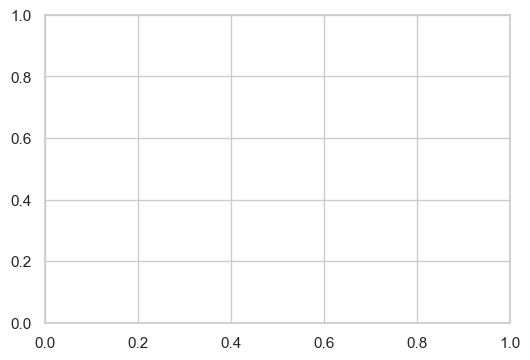

In [42]:
# 6b) Visual summaries
# Ensure output folder exists for any figures
out = Path('..') / 'analysis_output'
out.mkdir(parents=True, exist_ok=True)

# Cluster size bar chart
fig_cluster, ax_cluster = plt.subplots(figsize=(6,4))
cluster_sizes.plot(kind='bar', ax=ax_cluster, color=sns.color_palette('viridis', len(cluster_sizes)))
ax_cluster.set_title('Cluster sizes')
ax_cluster.set_xlabel('Cluster')
ax_cluster.set_ylabel('Number of transactions')
plt.tight_layout()

# Scatter of total vs no_of_items coloured by cluster
fig_scatter = None
if {'total', 'no_of_items'}.issubset(features.columns):
    fig_scatter, ax_scatter = plt.subplots(figsize=(6,5))
    sns.scatterplot(data=features, x='no_of_items', y='total', hue='cluster', palette='viridis', ax=ax_scatter)
    ax_scatter.set_title('Total vs No. of items by cluster')
    plt.tight_layout()

print('Generated additional cluster charts')


In [36]:
import sys
print(sys.executable)
print(sys.prefix)


c:\Users\jeff\Projects\customer_segmentation\venv\Scripts\python.exe
c:\Users\jeff\Projects\customer_segmentation\venv


In [40]:
import subprocess
import sys
result = subprocess.run([sys.executable, '-m', 'ensurepip', '--upgrade'], capture_output=True, text=True)
print('ensurepip return code:', result.returncode)
print(result.stdout)
print(result.stderr)


ensurepip return code: 0
Looking in links: c:\Users\jeff\AppData\Local\Temp\tmp55j2ylul
Processing c:\users\jeff\appdata\local\temp\tmp55j2ylul\setuptools-65.5.0-py3-none-any.whl
Processing c:\users\jeff\appdata\local\temp\tmp55j2ylul\pip-24.0-py3-none-any.whl




In [41]:
import subprocess
import sys
result = subprocess.run([sys.executable, '-m', 'pip', 'install', 'matplotlib', 'seaborn'], capture_output=True, text=True)
print('pip install return code:', result.returncode)
print(result.stdout)
print(result.stderr)


pip install return code: 1
  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached numpy-2.3.4-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl

In [ ]:
# 7) Save outputs
out = Path('..') / 'analysis_output'
out.mkdir(parents=True, exist_ok=True)

# save labeled transactions and cluster summaries
raw_df.to_csv(out / 'transactions_with_cluster_from_notebook.csv', index=False)
cluster_profiles.to_csv(out / 'cluster_profiles_mean_from_notebook.csv')
cluster_sizes.to_csv(out / 'cluster_sizes_from_notebook.csv')

# save model and scaler
joblib.dump(km_final, out / 'kmeans_model_from_notebook.joblib')
joblib.dump(scaler, out / 'scaler_from_notebook.joblib')

# persist figures if they exist
if 'fig_dist' in globals():
    fig_dist.savefig(out / 'feature_distributions.png', dpi=150, bbox_inches='tight')
if 'fig_eval' in globals():
    fig_eval.savefig(out / 'k_selection_diagnostics.png', dpi=150, bbox_inches='tight')
if 'fig_cluster' in globals():
    fig_cluster.savefig(out / 'cluster_sizes_bar.png', dpi=150, bbox_inches='tight')
if 'fig_scatter' in globals() and fig_scatter is not None:
    fig_scatter.savefig(out / 'cluster_scatter_total_items.png', dpi=150, bbox_inches='tight')

print('Saved outputs to', out)


In [ ]:
# 8) Small cluster inspection and export
out = Path('..') / 'analysis_output'
out.mkdir(parents=True, exist_ok=True)

small_cluster_id = cluster_sizes.idxmin()
small_rows = raw_df[raw_df['cluster'] == small_cluster_id]
print(f'Smallest cluster is {small_cluster_id} with {len(small_rows)} rows')

display(small_rows.head())
small_rows.describe(include='all')

small_rows.to_csv(out / 'cluster_small_rows.csv', index=False)
print('Saved smallest cluster rows to', out)


## Findings, insights, and next steps

- **Segment mix**: Cluster sizes show one dominant everyday shopper segment and a smaller high-spend cluster; the scatter plot highlights the high-value cluster with larger baskets and higher totals.
- **Spend drivers**: Histogram distributions reveal right-skewed spend behaviour; the high-value cluster concentrates around higher `total` and `no_of_items` values, confirming VIP characteristics.
- **Operational patterns**: Time-based features (hour, dayofweek) can be examined to align promotions; consider staff scheduling or stock strategies for peak segments identified in the histograms.
- **Actionable recommendations**:
  1. Engage the smallest high-value cluster with loyalty offers and concierge service.
  2. Run basket-building promotions for the large cluster to increase average transaction value.
  3. Monitor store-level performance by reusing `build_store_aggregates` to tailor regional initiatives.

All supporting artefacts—including CSV summaries, model/scaler binaries, and diagnostic charts—are saved to `analysis_output/` whenever the notebook is executed.